In [1]:
from IPython.display import display
from time import time
from typing import Sequence
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import polarsh as psh
from utils import plot_text_only, imshow
psh.set_visoptions_vispy(figsize=(600, 600))

## 1. Read a polarzied environment map (Stokes vector field) from files

### View the file (w/ our cubemap convention)

First of all, load four cube map images consisting of $s_0$, $s_1$, $s_2$, and $s_3$ Stokes components. Example images are contained in the `polarsh` package and they can be loaded by `polarsh.data_dir`. Each image file looks as follows.

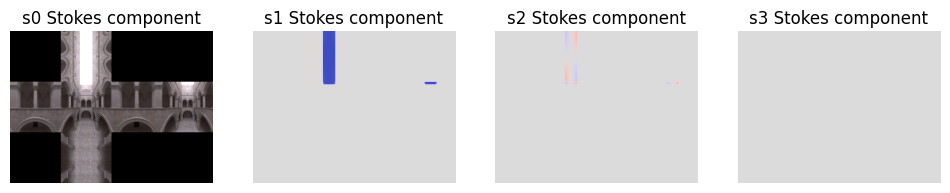

In [2]:
penv_file = psh.data_dir / "sponza_64_s%d.exr"

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, ax in enumerate(axes):
    img = psh.imread(str(penv_file) % i)
    imshow(ax, img, i>0, title=f"s{i} Stokes component") # A simple wrapper of `matplotlib.axes.Axes.imshow`

### Construct a `StokesField` instance from the images
Note that the four images above represent *numeric* Stokes components which are measured under a certain frame field. In `polarsh`. The actual *geometric* (physical) quantities of the polarized environment map can be understood as a Stokes vector field, which can be constructed as an instance in `StokesField` class.

In [3]:
stkF = psh.StokesField.from_cubeimage(penv_file)
print(f"{stkF = }")

stkF = StokesField[
  dom_type = <DomType.UNI: 0>,
  Stk.shape = [g:6, 64, 64 | c:3, | p:4],
]


We will handle several type of geometric quantities defined on a spherical domain, which indicate the set of all directions of rays. Representing spherical functions in planar images is not trivial and depends on choice of conventions. To emphasize the spherical domain and help users to image it, our spherical data types `SphereGrid`, `SphereFrameField`, `ScalarField`, and `StokesField` has a mehtod `.visualize()` which shows an interactive visualization.

Note that `.visualize()` methods are based on [VisPy](https://vispy.org/index.html) and return an `vispy.scene.SceneCanvas` instance. In Jupyter notebook, displaying an `vispy.scene.SceneCanvas` instance shows an interactive 3D visualization.

RFBOutputContext()

[Keyboard interface]
0: texture/point cloud mode for s0 component
A: hide/show global axes


CanvasBackend(css_height='600px', css_width='600px')
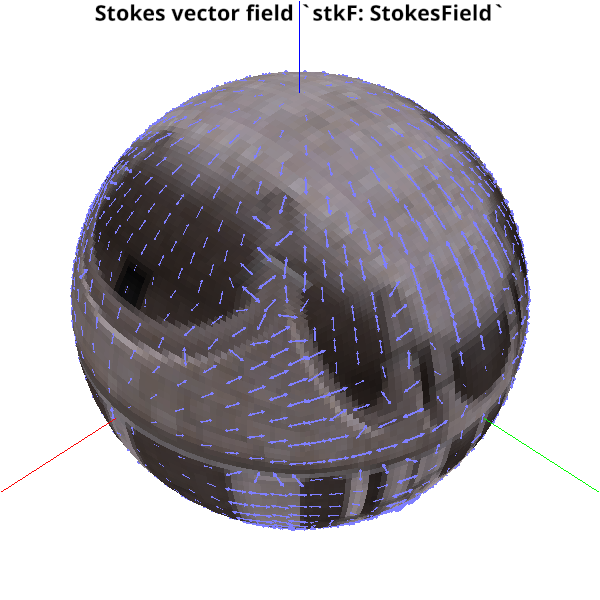

In [4]:
psh.set_visoptions_vispy(arrow_dsamp=4, arrow_scale=0.005, arrow_gamma=1/4, arrow_color=(0.5, 0.5, 1))
stkF.visualize(title="Stokes vector field `stkF: StokesField`")

-----
## 2. Representation of Stokes vector fields depends of frame fields.

### $s1$ and $s2$ components under cubemap frame field (combining six perspective frame fields).
Recall that Stokes component images are numeric quantities which depend on a frame field. `StokesField.from_cubeimage` which we used above assumes given images of Stokes components were measured under a certain frame field named *cubemap frame field* (`sphFF_cube` in the following code block).

In [5]:
sphFF_cube = stkF.SphFF
sphG = stkF.SphGrid
assert sphG is sphFF_cube.SphGrid
print(sphFF_cube)

SphereFrameField[
  dom_type = <DomType.UNI: 0>,
  shape = [6, 64, 64],
]


Note that calling `visualize()` methods under the scope of `with visualize_layout(...) as canvas` does not generate a new `vispy.scene.SceneCanvas` instance but add a view in the shared `canvas`. Such views of the `canvas` instance shares camera poses to visualization.

We also refer to M-Figure 5(e).

RFBOutputContext()

[Keyboard interface]
0: texture/point cloud mode for s0 component
A: hide/show global axes
[Keyboard interface]
A: hide/show global axes
G: hide/show sphere grids
F: show x(, y(, z)) axes for the frame field
[Keyboard interface]
V: texture/point cloud mode
A: hide/show global axes


CanvasBackend(css_width='1200px')
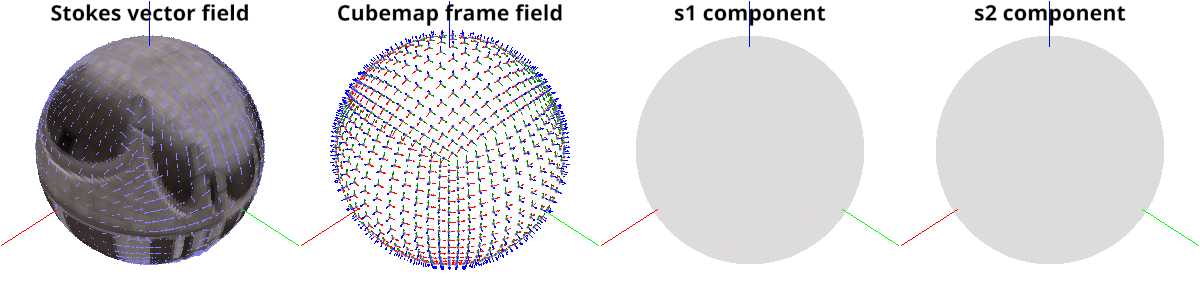

In [6]:
with psh.visualize_layout(1, 4, figsize=(1200, 300)) as canvas:
    stkF.visualize(title="Stokes vector field")
    sphFF_cube.visualize(marker_dsamp=4, arrow_dsamp=4, title="Cubemap frame field")
    stkF.s1_ScalarField().chan.rgb2gray().visualize(title="s1 component")
    stkF.s2_ScalarField().chan.rgb2gray().visualize(title="s2 component", help=False)

### Under $\theta\phi$-frame field
Let's check how we can measure the Stokes vector field under another frame field. We can get the *$\theta\phi$-frame field* as `sphFF_tp = sphG.ThetaPhiFrameField()`. Then `stkF.to_sphFF(sphFF_tp)` mehtods returns a `StokesField` instance which has internal representation with `sphFF_tp`. We can see its internal representation consisting of a frame field (mid-left) and four scalar fields (mid-right and rightmost, $s_0$ and $s_3$ are not visualized here) of each Stokes component differ from the ones above. However, Stokes vector fields (leftmost), which are geometric quantities, are identical even if their internal numeric representations are different.

We also refer to M-Figure 5(d).

RFBOutputContext()

CanvasBackend(css_width='1200px')
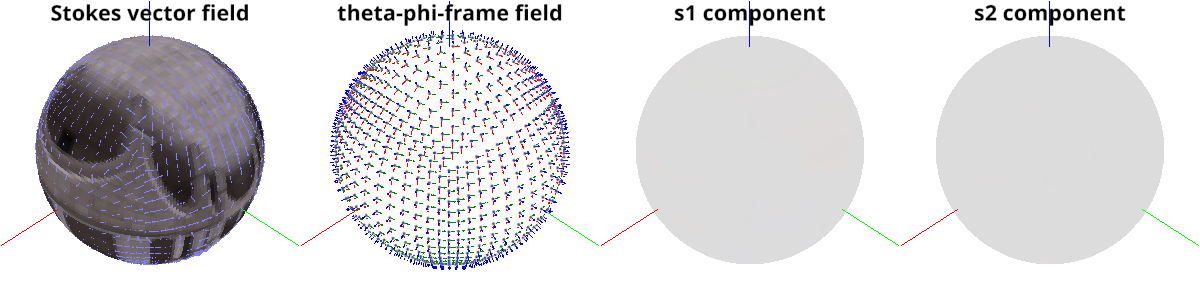

In [7]:
sphFF_tp = sphG.ThetaPhiFrameField()
stkF_tp = stkF.to_SphFF(sphFF_tp)

with psh.visualize_layout(1, 4, figsize=(1200, 300)) as canvas:
    stkF_tp.visualize(title="Stokes vector field", help=False)
    sphFF_tp.visualize(marker_dsamp=4, arrow_dsamp=4, title="theta-phi-frame field", help=False)
    stkF_tp.s1_ScalarField().chan.rgb2gray().visualize(title="s1 component", help=False)
    stkF_tp.s2_ScalarField().chan.rgb2gray().visualize(title="s2 component", help=False)

-----
## 3. Spin-2 Spherical Harmonics and Polarized Spherical Harmonics

### Visualize spin-2 SH for order (level) $l=2$
$$
\text{spin-2 spherical harmoncis: }\overset{\leftrightarrow}Y_{lm}
$$
We also refer to M-Figure 8.

RFBOutputContext()

[Keyboard interface]
A: hide/show global axes


CanvasBackend(css_height='250px', css_width='1250px')
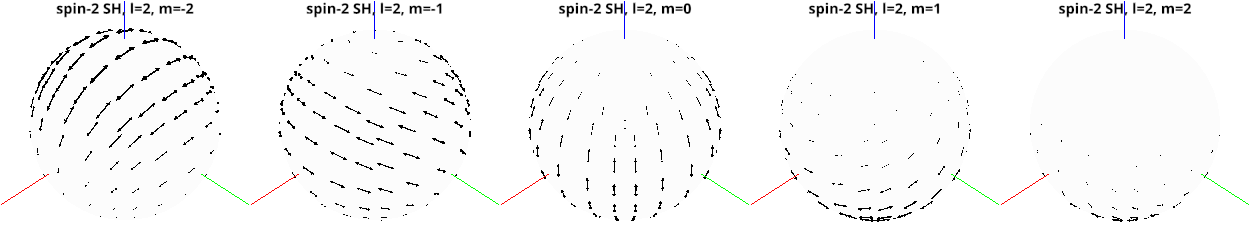

In [8]:
# ---------- Paramters ----------
l = 2
sphG = psh.SphereGridCube(6)

# ---------- Main ----------
level = l+1
psh.set_visoptions_vispy_default()
psh.set_visoptions_vispy(title_size=10)

stkF_s2SH = psh.StokesField.from_s2SH_upto(level, sphG) # spin-2 SH up to 0 <= l < level
with psh.visualize_layout(1, 5, figsize=(1250, 250)):
    for m in range(-2, 3):
        idx_lm = psh.lms2idx([2, m], psh.DomType.UNI)
        cfg = dict(arrow_scale=0.4, title=f"spin-2 SH, l=2, m={m}", help=(m == -2))
        stkF_s2SH.chan[idx_lm].visualize(**cfg)

Note that spin-2 SH $\overset{\leftrightarrow}Y_{lm}$ starts from $l\ge 2$. In `polarsh`, stores zero-valued functions for $l=0$ and $l=1$ for the sake of simplicity of implementation.

In [9]:
for idx, (l, m) in enumerate(psh.level2lms(2, psh.DomType.UNI)):
    if l > 0 and m == -l:
        print()
    print(f"[{l=}, {m=}]", end="\t")
    assert np.allclose(stkF_s2SH.chan[idx].Stk, 0)

[l=0, m=0]	
[l=1, m=-1]	[l=1, m=0]	[l=1, m=1]	

-----
## 4. PSH Coefficient vectors of Stokes vector fields

### PSH coefficient vector: frequency domain data
Rows indicate enumerating $\left(l,m\right)$ indices, i.e., $\left(0,0\right)$, $\left(1,-1\right)$,$\left(1,0\right)$, $\left(1,0\right)$, ...,
and columns indicate the $p$ index.

SHVec.coeff[0,:,:]
------------------------------------------------
l,m          p=0        p=1        p=2       p=3
-----  ---------  ---------  ---------  --------
0,0     1.39e+00   0.00e+00   0.00e+00  0.00e+00
1,-1   -2.85e-03   0.00e+00   0.00e+00  0.00e+00
1,0    -1.34e+00   0.00e+00   0.00e+00  0.00e+00
1,1     1.89e-04   0.00e+00   0.00e+00  0.00e+00
2,-2    2.02e-05  -8.99e-03   7.92e-07  0.00e+00
2,-1    3.28e-03   1.84e-05   7.30e-05  0.00e+00
2,0     1.47e+00   1.89e-01  -8.81e-07  0.00e+00
2,1    -9.61e-04  -1.95e-04  -3.70e-04  0.00e+00
2,2    -3.78e-01  -1.61e+00   1.76e-06  0.00e+00
3,-3    2.29e-03  -8.28e-07   1.35e-05  0.00e+00
3,-2   -8.65e-06   3.58e-02  -4.66e-07  0.00e+00
3,-1   -1.08e-03  -9.80e-05  -1.50e-04  0.00e+00
3,0    -9.64e-01  -3.99e-01   1.70e-06  0.00e+00
3,1     2.43e-04   2.99e-04   3.53e-04  0.00e+00
3,2     6.15e-01   1.34e+00  -7.79e-07  0.00e+00
3,3    -3.87e-04  -3.52e-04   4.02e-04  0.00e+00
4,-4   -6.77e-05   9.02e-03  -4.39e-08  0.00e+00
4

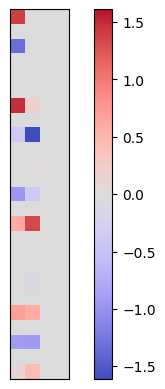

In [10]:
level = 5
shv = stkF.SHCoeff(level, psh.SHType.REAL)
print(shv.tabulate(0))              # `0` for the red color channel
shv.matshow(0, norm=mcolors.CenteredNorm()) # `0` for the red color channel
assert (shv.coeff[:, :4, 1:3] == 0).all() # No `l==0` and `l==1` for spin-2 SH (s1 and s2 Stokes components)

Using PSH notation $\overset{\leftrightarrow}Y_{lmp}$, the above can be simply done:

In [11]:
with psh.Tictoc("Assersion clear! Each coefficient is an inner product with a basis"):
    stkF_PSH = psh.StokesField.from_PSH_upto(level, stkF.SphGrid) # polarized SH
    for idx, (l, m) in enumerate(psh.level2lms(level, psh.DomType.UNI)):
        for p in range(4):
            assert np.allclose(shv.coeff[:, idx, p], stkF_PSH.chan[idx, p].inner(stkF))

Assersion clear! Each coefficient is an inner product with a basis: 2.8519 seconds.


### Reconstructed as a band-limited Stokes vector field

RFBOutputContext()

[Keyboard interface]
0: texture/point cloud mode for s0 component
A: hide/show global axes


CanvasBackend(css_height='500px')
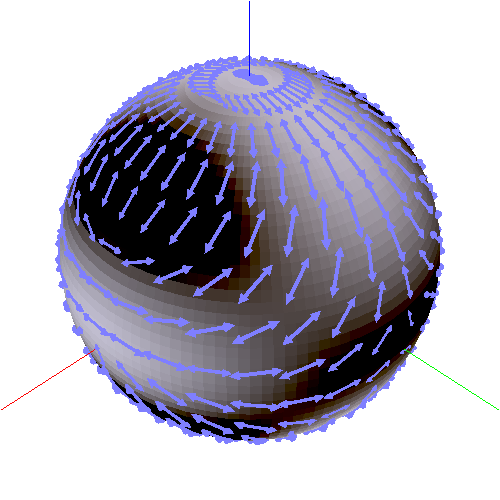

In [12]:
psh.set_visoptions_vispy(arrow_dsamp=4, arrow_scale=0.01, arrow_gamma=1/4, arrow_color=(0.5, 0.5, 1))
sphFF_er = psh.SphereFrameField.from_equirect(64, 128)
stkF_rec = psh.StokesField.from_SHCoeff(shv, sphFF_er)
stkF_rec.visualize()

## 5. Rotation invariance of polarized spherical harmonics
### Rotate in the PSH domain

In [13]:
# ---------- Paramters ----------
rotvec = [np.pi/2, 0, 0]
shm = psh.SHMat.from_rotation(rotvec, level, psh.CodType.POLAR4, psh.SHType.REAL)
print(shm)
print("\n[Tabulate]:")
print(shm.tabulate(()))

SHMat[c:  | N: 25, 25 | p: 4, 4][
  level = 5,
  dom_type = <DomType.UNI: 0>,
  cod_type = <CodType.POLAR4: 4>,
  sh_type = <SHType.REAL: 0>,
  coeff.shape = (25, 25, 4, 4),
  coeff.dtype = float64,
]

[Tabulate]:
SHMat.coeff[(),:,:,:,:]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

$Resulting vector = coefficeint matrix \times coefficient vector$

We also refer to M-Figure 10.

C:\Users\class\AppData\Local\Temp\ipykernel_38172\1971709619.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.95]);


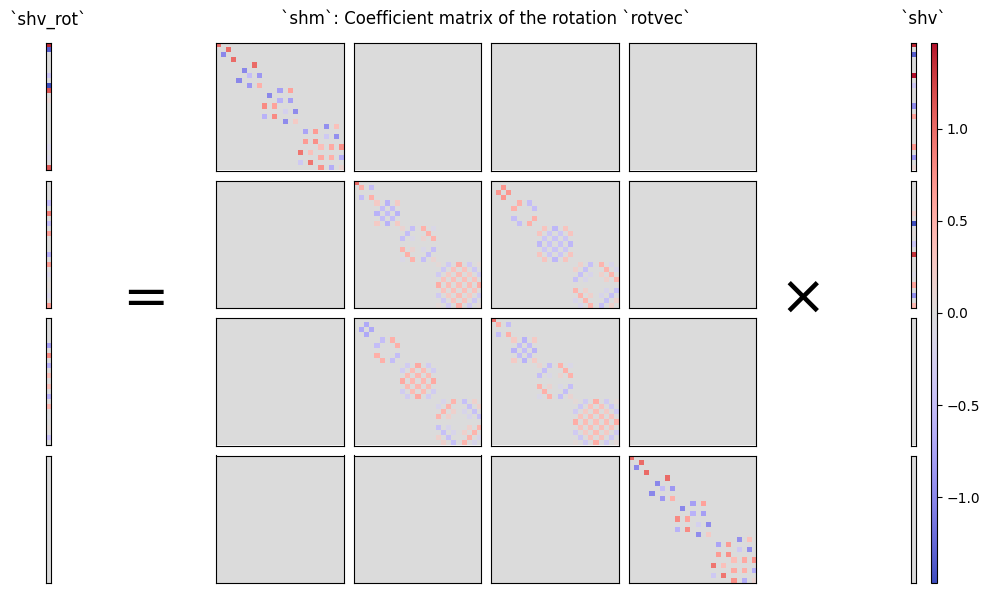

In [14]:
# ---------- Set a layout for visualization ----------
fig = plt.figure(figsize=(10, 6))
subfigs = fig.subfigures(1, 5, width_ratios=[1.5, 1, 7, 1, 1.5])
norm = mcolors.CenteredNorm()

def plot_text_only(fig, text):
    ax = fig.subplots()
    ax.text(0.0, 0.5, text, size=40)
    ax.set_axis_off()

# ---------- Compute coefficient rotation ----------
shv_rot = rotvec @ shv
assert shv_rot.allclose(shm @ shv)

# ---------- Show data ----------
shv_rot.matshow(0, title="`shv_rot`", long=True, norm=norm, colorbar=False, fig=subfigs[0])
plot_text_only(subfigs[1], "$=$")
shm.matshow(title="`shm`: Coefficient matrix of the rotation `rotvec`", norm=norm, colorbar=False, fig=subfigs[2])
plot_text_only(subfigs[3], r"$\times$")
shv.matshow(0, title="`shv`", long=True, norm=norm, fig=subfigs[4]);
fig.tight_layout(rect=[0, 0, 1, 0.95]);

PSH has rotation invariance, i.e., rotation in the angular domain (`stkF_rec.apply_rotation(rotvec)`) and one in the PSH domain (frequency domain, `stkF_rot`) yield the identical result.

RFBOutputContext()

CanvasBackend(css_height='600px', css_width='1200px')
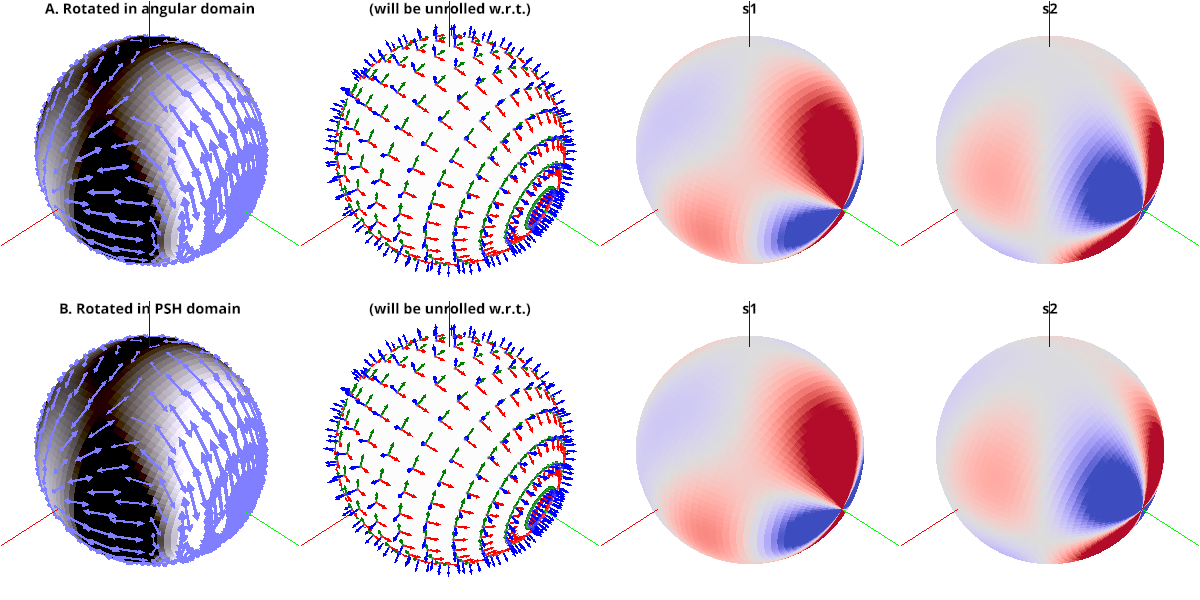

In [15]:
sphFF_er_rot = sphFF_er.apply_rotation(rotvec)
stkF_rot = psh.StokesField.from_SHCoeff(shv_rot, sphFF_er_rot)

stkF_list = [stkF_rec.apply_rotation(rotvec), stkF_rot]
titles = ["A. Rotated in angular domain", "B. Rotated in PSH domain"]

with psh.visualize_layout(2, 4, figsize=(1200, 600)):
    for stkF, title in zip(stkF_list, titles):
        stkF.visualize(title=title, help=False)
        stkF.SphFF.visualize(marker_dsamp=4, arrow_dsamp=4, arrow_size=0.1, title="(will be unrolled w.r.t.)", help=False)
        stkF.s1_ScalarField().chan.rgb2gray().visualize(title="s1", help=False)
        stkF.s2_ScalarField().chan.rgb2gray().visualize(title="s2", help=False)

### Unrolled $s_1$ and $s_2$ component images
We also refer to M-Figure 11.

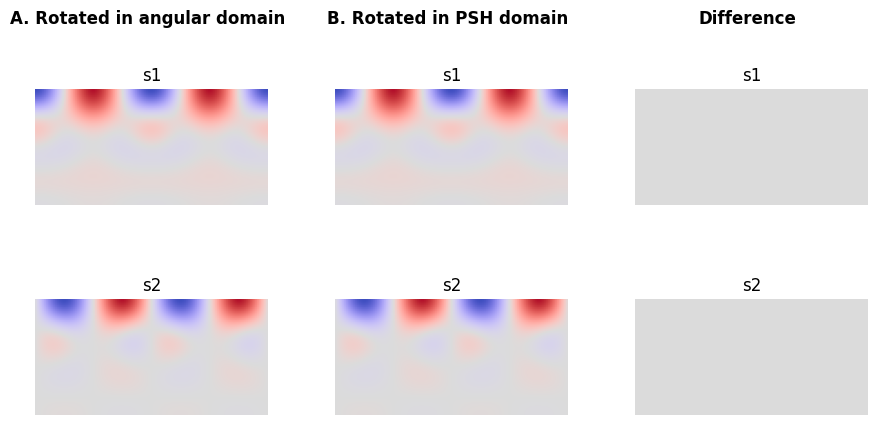

In [16]:
subfigs = plt.figure(figsize=(9, 5)).subfigures(1, 3)
norm = mcolors.CenteredNorm()

stkF_list3 = stkF_list + [stkF_list[0]-stkF_list[1]]
titles3 = titles + ["Difference"]
for i, (subfig, stkF, title) in enumerate(zip(subfigs, stkF_list3, titles3)):
    for s, (ax, img) in enumerate(zip(subfig.subplots(2, 1), [stkF.s1(), stkF.s2()])):
        imshow(ax, img[::-1], 1, norm=norm, title=f"s{s+1}")
    subfig.suptitle(title, fontweight="bold")

-----
## 5. Polarized Spherical Convolution
### A polarized convolution kernel

In [17]:
def k_num(theta):
    Z = np.zeros_like(theta)
    a = 5; b = 1.5
    k_1d = b * (np.exp(-a*theta**2) - np.exp(-a*np.pi**2))
    return np.stack([np.stack([k_1d, Z, Z, Z], -1), 
                     np.stack([Z, k_1d, Z, Z], -1),
                     np.stack([Z, Z, k_1d, Z], -1),
                     np.stack([Z, Z, Z, k_1d], -1)], -1)
k = psh.StokesConvKernel(k_num)
print(k)

StokesConvKernel[
  cod_type = <CodType.POLAR4: 4>,
  shape_chan = (),
]


### Visualizing spin 0/2-to-0/2 components for the kernel
We also refer to M-Figure 15(a-b).

In [18]:
sphG_cube5 = psh.SphereGridCube(5)
Fg = np.eye(3) # global (world) frame, which also indicate a local frame at the north pole (0, 0, 1).
k_on_delta_s0 = k.apply_delta(Fg, [1, 0, 0, 0], sphG_cube5)
k_on_delta_s1 = k.apply_delta(Fg, [0, 1, 0, 0], sphG_cube5)
k_on_delta_s3 = k.apply_delta(Fg, [0, 0, 0, 1], sphG_cube5)

RFBOutputContext()

[Keyboard interface]
V: texture/point cloud mode
A: hide/show global axes
[Keyboard interface]
A: hide/show global axes


CanvasBackend(css_height='900px', css_width='900px')
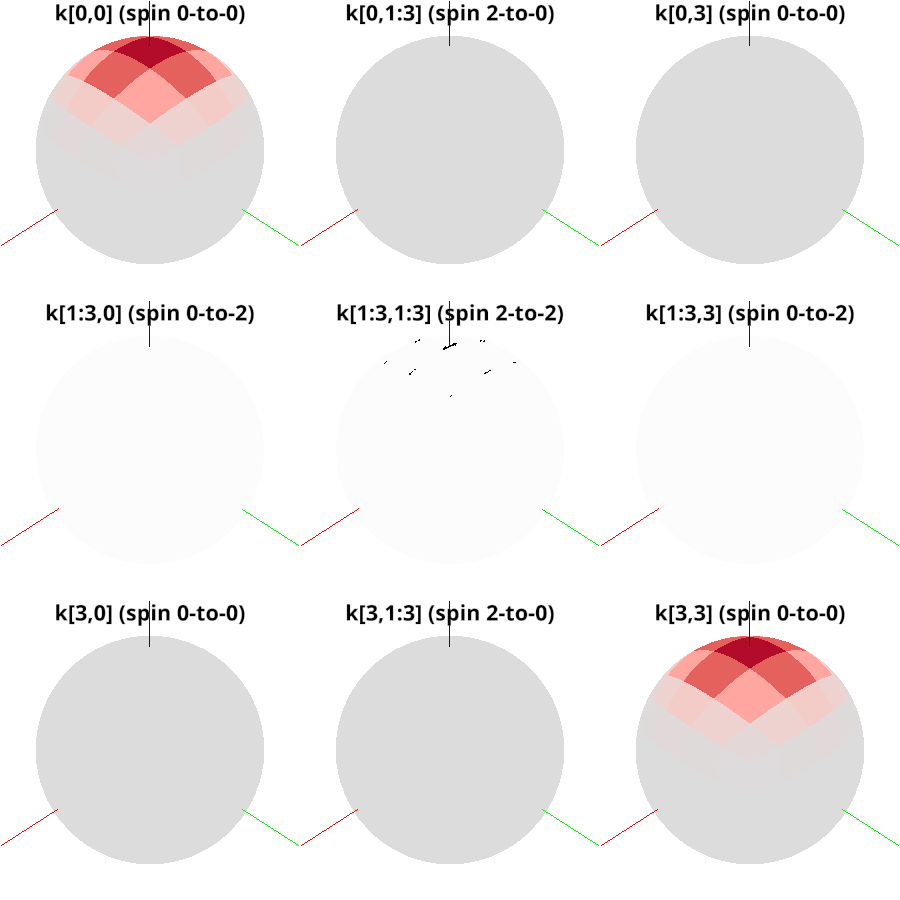

In [19]:
psh.set_visoptions_vispy_default()
with psh.visualize_layout(3, 3, figsize=(900, 900)):
    k_on_delta_s0.s0_ScalarField().visualize(title="k[0,0] (spin 0-to-0)")
    k_on_delta_s1.s0_ScalarField().visualize(title="k[0,1:3] (spin 2-to-0)", help=False)
    k_on_delta_s3.s0_ScalarField().visualize(title="k[0,3] (spin 0-to-0)", help=False)

    k_on_delta_s0.s12_StokesField().visualize(title="k[1:3,0] (spin 0-to-2)", arrow_scale=0.1)
    k_on_delta_s1.s12_StokesField().visualize(title="k[1:3,1:3] (spin 2-to-2)", arrow_scale=0.1, help=False)
    k_on_delta_s3.s12_StokesField().visualize(title="k[1:3,3] (spin 0-to-2)", arrow_scale=0.1, help=False)

    k_on_delta_s0.s3_ScalarField().visualize(title="k[3,0] (spin 0-to-0)", help=False)
    k_on_delta_s1.s3_ScalarField().visualize(title="k[3,1:3] (spin 2-to-0)", help=False)
    k_on_delta_s3.s3_ScalarField().visualize(title="k[3,3] (spin 0-to-0)", help=False)

### Polarzied spherical convolution
For a quick demonstration, we use a low-frequency low-resolution Stokes vector field as an input of polarized spherical convolution.

In [20]:
level = 6
shv = psh.SHVec.from_npz_file("input/SHVec_sponza_1024_L100.npz").cut(level)
print(shv, "\n")

sphG = psh.SphereGridEquirect(32, 64)
sphFF = sphG.ThetaPhiFrameField()
with psh.Tictoc("`shv: SHVec` to `stkF_rec: StokesField`"):
    stkF_rec = psh.StokesField.from_SHCoeff(shv, sphFF)
print(stkF_rec)

SHVec[c: 3, | N: 36 | p: 4][
  level = 6,
  cod_type = <CodType.POLAR4: 4>,
  sh_type = <SHType.REAL: 0>,
  coeff.shape = (3, 36, 4),
  coeff.dtype = float64,
] 

`shv: SHVec` to `stkF_rec: StokesField`: 0.0210 seconds.
StokesField[
  dom_type = <DomType.UNI: 0>,
  Stk.shape = [g:32, 64 | c:3, | p:4],
]


In the angular domain, polarzied spherical convolution can be done by `psh.StokesConvKernel.apply(psh.StokesField)`.

In [21]:
with psh.Tictoc("Applying polarized spherical convolution in the angular domain"):
    stkF_conv = k.apply(stkF_rec)

Applying polarized spherical convolution in the angular domain: 10.6361 seconds.


### Polarzied spherical convolution theorem: convolution in PSH coefficients
In the frequency domain, PSH convolution can be done by `psh.SHConv @ psh.SHVec`.

In [22]:
with psh.Tictoc("Applying polarized spherical convolution in the frequency (PSH) domain"):
    shConv = k.SHCoeff(level)
    shv_conv = shConv @ shv

with psh.Tictoc("`shv_conv: SHVec` to `stkF_conv_rec: StokesField`"):
    stkF_conv_rec = psh.StokesField.from_SHCoeff(shv_conv, sphFF)

Applying polarized spherical convolution in the frequency (PSH) domain: 0.0035 seconds.
`shv_conv: SHVec` to `stkF_conv_rec: StokesField`: 0.0199 seconds.


### Results
Polarzied spherical convolution in both (angular vs. frequency) domains produce the same result, which has blurred signals in polarized intensity. However, the frequency domain (PSH) convolution is much faster.

RFBOutputContext()

CanvasBackend(css_height='400px', css_width='800px')
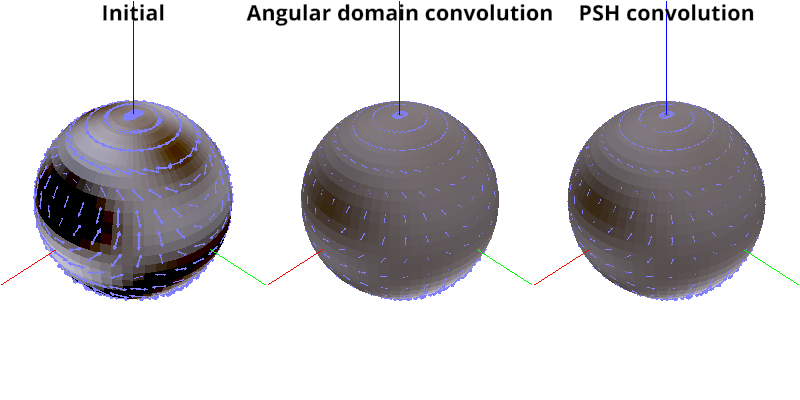

In [23]:
stk_list = [stkF_rec, stkF_conv, stkF_conv_rec, stkF_conv - stkF_conv_rec]
titles = ["Initial", "Angular domain convolution", "PSH convolution", "Diff."]

cfg = dict(arrow_dsamp=2, arrow_gamma=1/2.2, arrow_color=(0.5, 0.5, 1.0), help=False)
with psh.visualize_layout(1, 3, figsize=(800, 400)):
    for stkF, title in zip(stk_list[:3], titles[:3]):
        stkF.visualize(**cfg, title=title)

We also refer to M-Figure 16.

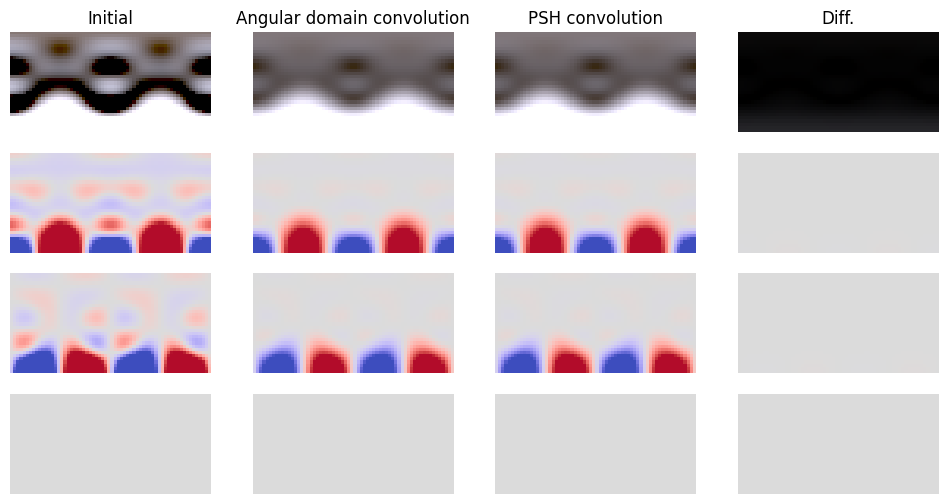

In [24]:
fig, axes = plt.subplots(4, 4, figsize=(12, 6))
norm = mcolors.Normalize(-1, 1)
for (i, j), ax in np.ndenumerate(axes):
    imshow(ax, stk_list[j].Stk[..., i], i, norm)
    if i == 0:
        ax.set_title(titles[j])